In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env=gym.make('FrozenLake-v0')

In [7]:
Q=np.zeros([env.observation_space.n,env.action_space.n])

In [8]:
learning_rate=.85
dis=.99 #gamma
num_episodes=2000

0.676
[[5.72598096e-01 2.06126779e-02 1.96876375e-02 3.08805337e-02]
 [1.52517687e-02 4.24025184e-04 4.38978769e-03 7.76732660e-01]
 [7.71479060e-03 6.27198328e-01 1.97851800e-03 1.82894794e-02]
 [3.71846248e-04 2.33338990e-03 2.13299374e-03 4.23357980e-01]
 [6.16336168e-01 2.38122686e-03 4.43331744e-03 4.41048594e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.84032645e-02 8.30432928e-06 1.64067688e-04 2.86846018e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.93418896e-05 5.67171341e-06 3.28096567e-03 4.10243087e-01]
 [1.19977201e-02 7.90324590e-01 0.00000000e+00 1.35559594e-02]
 [9.69529865e-01 2.56416710e-04 5.53296016e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.84167468e-01 1.07291250e-01]
 [0.00000000e+00 9.99498034e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.

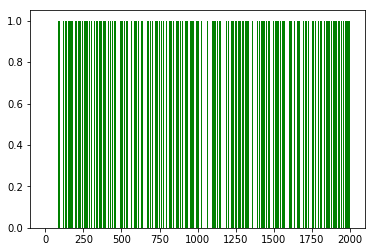

In [12]:
#a    b    c
#0.5 0.7 0.3
#0.1 0.0 0.7

rList=[]
for i in range(num_episodes):
    state=env.reset()
    rAll=0
    done=False
    while not done:
        action=np.argmax(Q[state,:]+np.random.randn(1,env.action_space.n)/(i+1))
        new_state, reward, done, _ =env.step(action)
        Q[state,action]=(1-learning_rate)*Q[state,action]+learning_rate*(reward+dis*np.max(Q[new_state,:]))
        rAll+=reward
        state=new_state
    rList.append(rAll)
print(sum(rList)/num_episodes)        
print(Q)
plt.bar(range(len(rList)), rList, color='green')
plt.show()
        
        
        

In [11]:
#np.random.randn(1,env.action_space.n)

array([[ 0.38323178, -0.83246146, -1.03562412,  0.21742197]])

In [13]:
import tensorflow as tf
import tensorflow.contrib.slim as slim #tf-slim
import numpy as np

In [ ]:
#손잡이:4개, 밴딧(슬롯머신):3대
#각각의 밴딧은 각각의 손잡이에 대해 서로 다른 성공 확률을 가지고 있음
#최고의 결과를 얻어내기 위한 동작

#에이전트가 슬롯머신에 대해 가장 자주 양의 보상을
#주는 손잡이를 항상 선택하도록 하는 방법을 학습


In [42]:
class contextual_bandit():#밴딧 클래스
    def __init__(self): #태어나는 아기(객체)
        self.state=0    #슬롯머신 상태,아기의 몸무게(속성)
        self.bandits=np.array([[0.2,0,-0.1,-5],[0.1,-5,1,0.25],[-5,5,5,5]]) #슬롯머신(밴딧) 3대
        self.num_bandits=self.bandits.shape[0]
        self.num_actions=self.bandits.shape[1]
    def getBandit(self):
        self.state=np.random.randint(0,len(self.bandits))
        return self.state
    def pullArm(self, action):#action:레버(4개의 레버중에서 당긴 레버의 번호)
        bandit=self.bandits[self.state, action]
        result=np.random.randn(1)
        if result>bandit:
            return 1
        else:
            return -1

In [43]:
class agent(): #에이전트
    def __init__(self, lr, s_size, a_size):
        #에이전트 초기화
        self.state_in=tf.placeholder(shape=[1], dtype=tf.int32)
        state_in_OH=slim.one_hot_encoding(self.state_in, s_size)
        output=slim.fully_connected(state_in_OH, a_size, biases_initializer=None, activation_fn=tf.nn.sigmoid, weights_initializer=tf.ones_initializer())
        self.output=tf.reshape(output,[-1])
        self.chosen_action=tf.argmax(self.output,0)
        
        self.reward_holder=tf.placeholder(shape=[1], dtype=tf.float32)
        self.action_holder=tf.placeholder(shape=[1], dtype=tf.int32)
        self.responsible_weight=tf.slice(self.output,self.action_holder, [1])
        self.loss=-(tf.log(self.responsible_weight)*self.reward_holder)
        optimizer=tf.train.GradientDescentOptimizer(learning_rate=lr)
        self.update=optimizer.minimize(self.loss)    

In [44]:
#학습
tf.reset_default_graph()
cBandit=contextual_bandit() #객체 생성
myAgent=agent(lr=0.001,s_size=cBandit.num_bandits, a_size=cBandit.num_actions) #객체 생성
weights=tf.trainable_variables()[0]

total_episodes=10000
total_reward=np.zeros([cBandit.num_bandits, cBandit.num_actions])
e=0.1
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i=0
    while i < total_episodes:
        s=cBandit.getBandit()
        
        if np.random.rand(1)<e: #exploration
            action=np.random.randint(cBandit.num_actions)
        else:  #exploit
            action=sess.run(myAgent.chosen_action,feed_dict={myAgent.state_in:[s]})
        
        reward=cBandit.pullArm(action)
        
        #네트워크 업데이트
        feed_dict={myAgent.reward_holder:[reward],myAgent.action_holder:[action],myAgent.state_in:[s]}
        _, ww=sess.run([myAgent.update, weights], feed_dict=feed_dict)
        
        total_reward[s,action]+=reward
        
        if i%500==0:
            print("각 보상의 평균 : "+str(cBandit.num_bandits)+" 밴딧:"+str(np.mean(total_reward,axis=1)))
        i+=1
        

W1001 14:51:26.887183  8060 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py:2563: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


각 보상의 평균 : 3 밴딧:[0.   0.   0.25]
각 보상의 평균 : 3 밴딧:[33.   39.25 37.  ]
각 보상의 평균 : 3 밴딧:[74.75 78.75 64.75]
각 보상의 평균 : 3 밴딧:[108.   120.   103.75]
각 보상의 평균 : 3 밴딧:[140.75 156.   145.5 ]
각 보상의 평균 : 3 밴딧:[177.25 197.5  179.5 ]
각 보상의 평균 : 3 밴딧:[215.5  235.25 213.  ]
각 보상의 평균 : 3 밴딧:[258.25 270.75 246.75]
각 보상의 평균 : 3 밴딧:[298.25 308.25 281.75]
각 보상의 평균 : 3 밴딧:[337.25 345.75 313.75]
각 보상의 평균 : 3 밴딧:[373.75 384.5  350.5 ]
각 보상의 평균 : 3 밴딧:[410.25 426.5  386.  ]
각 보상의 평균 : 3 밴딧:[447.75 461.   425.  ]
각 보상의 평균 : 3 밴딧:[481.   497.75 458.  ]
각 보상의 평균 : 3 밴딧:[519.5  535.   494.25]
각 보상의 평균 : 3 밴딧:[561.25 575.5  525.5 ]
각 보상의 평균 : 3 밴딧:[597.5  613.   565.25]
각 보상의 평균 : 3 밴딧:[635.75 648.25 600.75]
각 보상의 평균 : 3 밴딧:[676.   685.25 637.5 ]
각 보상의 평균 : 3 밴딧:[714.25 721.25 675.75]


In [25]:
nnet_inputs=tf.placeholder(tf.float32,[None,None,None,1])
net_outputs=tf.placeholder(tf.float32,[None,None,None,1])

#1번째 계층
w=tf.Variable(tf.random_normal([11,11,1,10]))
b=tf.Variable(tf.random_normal([10]))
net=tf.nn.conv2d(net_inputs, filter=w, strides=[1,4,4,1], padding='SAME')
net=tf.nn.bias_add(net,b)
net=tf.nn.relu(net)

w=tf.Variable(tf.random_normal([5,5,10,20]))
#2번째 계층
net=tf.nn.conv2d(net, filter=w, strides=[1,2,2,1], padding='SAME')
net=tf.nn.relu(net)

#3번째 계층
w=tf.Variable(tf.random_normal([3,3, 20,50]))
net=tf.nn.conv2d(net, filter=w, strides=[1,2,2,1], padding='SAME')
net=tf.nn.relu(net)

In [29]:
tf.trainable_variables()[0]

train_var=[var for var in tf.trainable_variables()]
for tv in train_var:
    print(tv)

<tf.Variable 'Variable:0' shape=(11, 11, 1, 10) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'Variable_2:0' shape=(5, 5, 10, 20) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(3, 3, 20, 50) dtype=float32_ref>
<tf.Variable 'Variable_4:0' shape=(11, 11, 1, 10) dtype=float32_ref>
<tf.Variable 'Variable_5:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'Variable_6:0' shape=(5, 5, 10, 20) dtype=float32_ref>
<tf.Variable 'Variable_7:0' shape=(3, 3, 20, 50) dtype=float32_ref>
